In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Ceará - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_CE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Ceará - Desemprego,Ceará - Consumo de Cimento (t),Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,8.274459,81.265,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,8.268512,65.200,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,8.262564,55.165,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,8.256617,53.928,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,8.250670,65.334,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


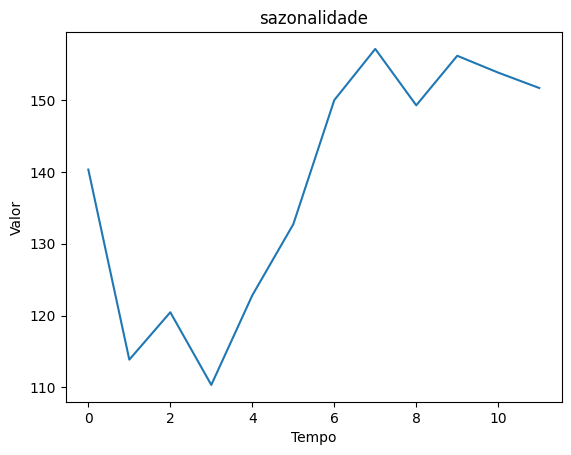

,sazonalidade
sazonalidade,
0,140.323598
1,113.860842
2,120.457232
3,110.343116
4,122.812310
5,132.708078
6,149.986831
7,157.117330
8,149.266241


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Ceará - Consumo de Cimento (t)
0,2003-1,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,140.323598,81.265
1,2003-2,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,113.860842,65.200
2,2003-3,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,120.457232,55.165
3,2003-4,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,110.343116,53.928
4,2003-5,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,122.812310,65.334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.812310,NaN
245,2023-6,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.708078,NaN
246,2023-7,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.986831,NaN
247,2023-8,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.117330,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      91.341
1      69.730
2      77.682
3      66.140
4      76.289
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Ceará - Consumo de Cimento (t), Length: 249, dtype: float64

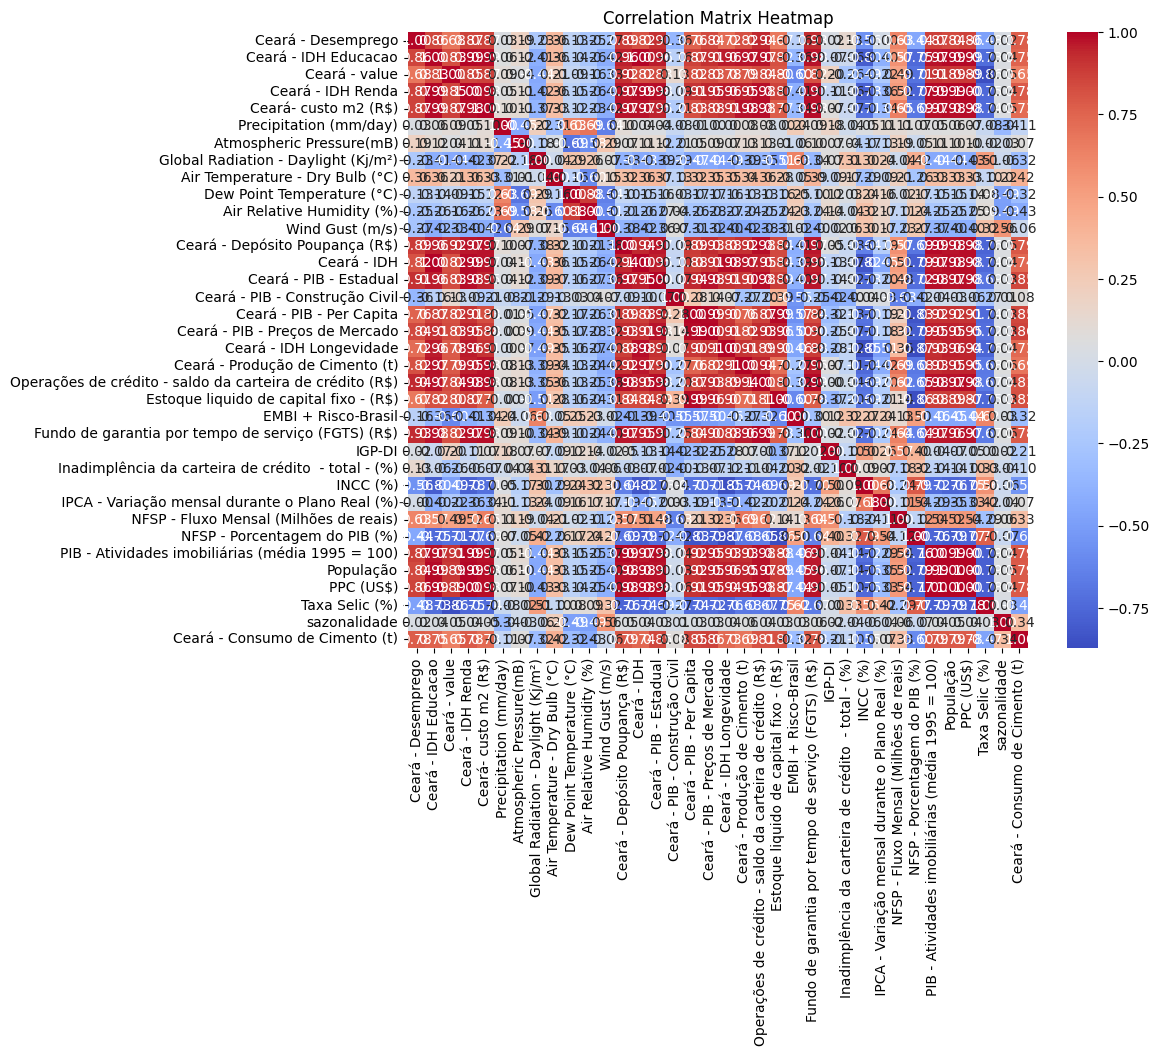

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Ceará - Desemprego,8.646726e+04
1,Ceará - IDH Educacao,4.072344e+09
2,Ceará - value,1.527632e+05
3,Ceará - IDH Renda,2.705245e+07
4,Ceará- custo m2 (R$),8.022706e+05
5,Precipitation (mm/day),5.984652e+01
6,Atmospheric Pressure(mB),1.404268e+07
7,Global Radiation - Daylight (Kj/m²),1.113481e+01
8,Air Temperature - Dry Bulb (°C),7.948795e+05
9,Dew Point Temperature (°C),3.979738e+05


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 3


,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,6.965352e+07,4.525724e+06,7.532751,107.673000,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,140.323598
1,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,6.974354e+07,4.530359e+06,7.535808,107.237962,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,113.860842
2,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,6.983356e+07,4.534994e+06,7.538865,108.742184,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,120.457232
3,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,6.992358e+07,4.539629e+06,7.541921,109.391112,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,110.343116
4,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,7.001361e+07,4.544265e+06,7.544978,111.602457,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,122.812310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,10.562902,0.733462,0.410592,0.661651,26842.534511,1.224027,1010.396718,1365.409422,27.247565,20.809203,69.087662,2.859211,1.190677e+07,8.242098e+07,4.588679e+06,7.748357,204.933909,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,157.117330
200,10.558325,0.733415,0.413089,0.661620,27069.198791,1.244228,1009.735187,1397.506038,27.487216,20.902118,68.486615,2.924760,1.206148e+07,8.232733e+07,4.590358e+06,7.746141,206.160149,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,149.266241
201,10.553748,0.733368,0.416107,0.661588,27299.775810,1.455208,1009.252001,1353.741123,27.615918,21.201740,69.231818,2.764745,1.221619e+07,8.223367e+07,4.592037e+06,7.743925,208.133491,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,156.163355
202,10.549171,0.733321,0.419302,0.661557,27542.053713,1.798267,1008.948838,1248.780910,27.631455,21.645840,71.083211,2.514838,1.237090e+07,8.214002e+07,4.593716e+06,7.741709,209.173097,3.425371e+06,7.700533e+06,262.843441,1.16521

In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.000000,0.069030,0.000000,0.000000,0.371316,0.403687,0.180477,0.384334,0.492771,0.536124,0.765983,0.000000,0.000000,0.000000,0.000000,0.004216,0.000000,0.000000,0.108706,0.014287,0.803606,0.790380,1.000000,1.000000,0.301039,1.000000,0.000000,0.000000,0.000000,0.827406
1,0.007255,0.069158,0.007512,0.004933,0.371437,0.403487,0.180477,0.384609,0.492835,0.536078,0.765283,0.002661,0.006268,0.014215,0.010589,0.000000,0.000190,0.011007,0.058377,0.004635,0.752660,0.788742,0.968938,0.921240,0.301792,0.966038,0.001495,0.007652,0.003428,0.719915
2,0.014509,0.068512,0.015023,0.009432,0.371507,0.403371,0.180477,0.384770,0.492873,0.536051,0.764874,0.005323,0.012535,0.028430,0.021178,0.014579,0.000203,0.022015,0.100305,0.000909,0.728503,0.788333,0.948438,0.873107,0.294922,0.928087,0.002989,0.015303,0.006967,1.000000
3,0.021764,0.065499,0.022535,0.013677,0.371514,0.403359,0.180477,0.384787,0.492877,0.536049,0.764830,0.007984,0.018803,0.042645,0.031767,0.020868,0.000349,0.033022,0.211591,0.000000,0.690036,0.787696,0.928794,0.851659,0.279215,0.886653,0.004484,0.022955,0.010587,0.656464
4,0.029019,0.061661,0.030047,0.017723,0.467057,0.365918,0.215582,0.360507,0.559751,0.599824,0.710931,0.010646,0.025071,0.056860,0.042356,0.042300,0.000809,0.044030,0.358835,0.002131,0.662845,0.784532,0.970421,0.823277,0.285466,0.839542,0.006327,0.030606,0.014112,0.810086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.989200,0.908430,0.989348,0.946132,0.294543,0.509991,0.112306,0.461355,0.266562,0.356230,0.668451,0.921561,0.888918,0.193067,0.746920,0.946857,0.964083,0.749512,0.164662,0.843595,0.925754,0.200335,0.437606,0.269755,0.988898,0.004294,0.987846,0.985587,0.991307,0.096760
200,0.988600,0.927624,0.988756,0.959030,0.301929,0.425240,0.114946,0.563052,0.298145,0.323228,0.698701,0.941171,0.882398,0.198216,0.739243,0.958741,0.972616,0.742205,0.166152,0.841613,0.940916,0.197374,0.449028,0.321896,0.989787,0.001943,0.990212,0.989191,0.993698,0.092442
201,0.988000,0.950819,0.988165,0.972152,0.379067,0.363336,0.111347,0.617668,0.399992,0.364145,0.624856,0.960781,0.875877,0.203365,0.731565,0.977867,0.982801,0.734899,0.171580,0.899079,0.983770,0.173835,0.471116,0.386916,0.966651,0.001563,0.992579,0.992794,0.995919,0.063859
202,0.987400,0.975376,0.987573,0.985939,0.504494,0.324497,0.102714,0.624261,0.550949,0.465800,0.509526,0.980390,0.869357,0.208514,0.723887,0.987943,0.992089,0.727592,0.177868,0.970196,0.973718,0.162834,0.496672,0.432519,0.988004,0.001600,0.996289,0.996397,0.997943,0.046786


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.000000,0.069030,0.000000,0.000000,0.371316,0.403687,0.180477,0.384334,0.492771,0.536124,0.765983,0.000000,0.000000,0.000000,0.000000,0.004216,0.000000,0.000000,0.108706,0.014287,0.803606,0.790380,1.000000,1.000000,0.301039,1.000000,0.000000,0.000000,0.000000,0.827406
1,0.007255,0.069158,0.007512,0.004933,0.371437,0.403487,0.180477,0.384609,0.492835,0.536078,0.765283,0.002661,0.006268,0.014215,0.010589,0.000000,0.000190,0.011007,0.058377,0.004635,0.752660,0.788742,0.968938,0.921240,0.301792,0.966038,0.001495,0.007652,0.003428,0.719915
2,0.014509,0.068512,0.015023,0.009432,0.371507,0.403371,0.180477,0.384770,0.492873,0.536051,0.764874,0.005323,0.012535,0.028430,0.021178,0.014579,0.000203,0.022015,0.100305,0.000909,0.728503,0.788333,0.948438,0.873107,0.294922,0.928087,0.002989,0.015303,0.006967,1.000000
3,0.021764,0.065499,0.022535,0.013677,0.371514,0.403359,0.180477,0.384787,0.492877,0.536049,0.764830,0.007984,0.018803,0.042645,0.031767,0.020868,0.000349,0.033022,0.211591,0.000000,0.690036,0.787696,0.928794,0.851659,0.279215,0.886653,0.004484,0.022955,0.010587,0.656464
4,0.029019,0.061661,0.030047,0.017723,0.467057,0.365918,0.215582,0.360507,0.559751,0.599824,0.710931,0.010646,0.025071,0.056860,0.042356,0.042300,0.000809,0.044030,0.358835,0.002131,0.662845,0.784532,0.970421,0.823277,0.285466,0.839542,0.006327,0.030606,0.014112,0.810086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.996150,0.659442,0.996203,0.843702,0.458860,0.461340,0.113040,0.455909,0.222904,0.337820,0.621409,0.771712,0.954306,0.159201,0.833327,0.779521,0.905889,0.828698,0.187214,0.772088,0.306496,0.228511,0.005731,0.000000,0.770932,0.039832,0.940133,0.945526,0.954021,0.142213
188,0.995600,0.677720,0.995660,0.848819,0.520103,0.405138,0.112689,0.524930,0.282527,0.339531,0.621842,0.774228,0.950357,0.158765,0.826794,0.791675,0.910701,0.823090,0.197767,0.765287,0.374969,0.204051,0.037761,0.029504,0.843110,0.036772,0.946259,0.948494,0.957505,0.121167
189,0.995050,0.698001,0.995118,0.854104,0.564956,0.382058,0.109021,0.581322,0.397846,0.384751,0.564227,0.776745,0.946408,0.158330,0.820262,0.804142,0.918025,0.817482,0.203626,0.822408,0.426663,0.163703,0.087044,0.043125,0.852836,0.032169,0.952386,0.951462,0.960752,0.085226
190,0.994500,0.719263,0.994575,0.860041,0.551344,0.356424,0.110534,0.717070,0.536946,0.402133,0.521766,0.779261,0.942459,0.157894,0.813730,0.811669,0.924362,0.811875,0.204541,0.894295,0.491223,0.131737,0.118264,0.059756,0.901189,0.026694,0.956511,0.954429,0.963720,0.124421


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       91.341
1       69.730
2       77.682
3       66.140
4       76.289
        ...   
187    188.585
188    193.975
189    193.778
190    180.726
191    183.494
Name: Ceará - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 30)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
156,0.953215,0.366280,0.982803,0.690673,0.400011,0.369494,0.116036,0.932432,0.699546,0.396621,0.503824,0.634439,0.989702,0.313153,0.934111,0.762486,0.916170,0.960324,0.442089,0.839309,0.068901,0.587637,0.194855,0.431209,0.413661,0.036321,0.809361,0.849576,0.841791,0.468318
157,0.955403,0.363335,0.983420,0.696100,0.433654,0.381871,0.117921,1.000000,0.742458,0.391589,0.329320,0.640408,0.990560,0.299285,0.933394,0.763088,0.912459,0.956993,0.467381,0.801704,0.032121,0.643262,0.182507,0.379453,0.455637,0.033116,0.809984,0.852720,0.845267,0.411842
158,0.957591,0.361270,0.984037,0.701444,0.461212,0.421743,0.112278,0.970164,0.706750,0.386842,0.065936,0.646377,0.991418,0.285416,0.932677,0.767251,0.908995,0.953662,0.483414,0.790541,0.022138,0.709146,0.168812,0.332832,0.444532,0.030640,0.810608,0.855864,0.849072,0.445079
159,0.959779,0.358630,0.984654,0.706951,0.324752,0.462387,0.111021,0.884054,0.580585,0.351283,0.000000,0.652347,0.992277,0.271547,0.931960,0.763064,0.905562,0.950331,0.485402,0.775928,0.029764,0.729647,0.152959,0.313954,0.426520,0.028514,0.811231,0.859008,0.852964,0.424429
160,0.961967,0.358103,0.985271,0.712484,0.260173,0.529970,0.115298,0.839303,0.404744,0.259854,0.090620,0.658316,0.993135,0.257678,0.931244,0.759192,0.902608,0.947000,0.480289,0.772954,0.056928,0.729821,0.137613,0.294856,0.443124,0.026816,0.811034,0.862152,0.856928,0.481307
161,0.964155,0.360032,0.985888,0.717912,0.195853,0.563593,0.116450,0.757095,0.246562,0.199623,0.279399,0.664285,0.993993,0.243809,0.930527,0.761474,0.899226,0.943668,0.466293,0.770874,0.061888,0.716852,0.163171,0.308016,0.437764,0.025008,0.810837,0.865295,0.860686,0.545277
162,0.966344,0.366057,0.986504,0.722611,0.182319,0.535759,0.117106,0.675512,0.160394,0.188241,0.523272,0.670254,0.994851,0.229940,0.929810,0.766461,0.896766,0.940337,0.446692,0.763405,0.028761,0.746600,0.115114,0.297600,0.424379,0.024308,0.810640,0.868439,0.864433,0.411731
163,0.968532,0.375609,0.987121,0.727182,0.185712,0.490526,0.120655,0.703184,0.147651,0.162898,0.638037,0.676224,0.995709,0.216071,0.929093,0.773680,0.894216,0.937006,0.423280,0.760489,0.049338,0.803166,0.099148,0.258616,0.427657,0.024210,0.813009,0.871583,0.868468,0.517393
164,0.970720,0.384863,0.987738,0.731955,0.156628,0.424433,0.120598,0.744886,0.200285,0.172014,0.696660,0.682193,0.996567,0.202202,0.928377,0.777344,0.892500,0.933675,0.387661,0.754812,0.076797,0.850835,0.092609,0.249254,0.410864,0.025786,0.815379,0.874727,0.872546,0.484026
165,0.972908,0.395567,0.988355,0.736863,0.200422,0.356475,0.117640,0.752919,0.297907,0.230806,0.686799,0.688162,0.997426,0.188333,0.927660,0.782428,0.891376,0.930344,0.351781,0.801517,0.077481,0.875483,0.088481,0.255443,0.380278,0.027984,0.817748,0.877871,0.876542,0.460061


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1038055695, 219244274, 1941177279, 1431661827, 1140020439, 2050050739, 1935586480, 1511980117, 203446229, 1666834211]


Step: 0 ___________________________________________
val_loss: 738.5169067382812
winner_seed: 1038055695


Step: 1 ___________________________________________
val_loss: 776.8033447265625


Step: 2 ___________________________________________
val_loss: 1154.466796875


Step: 3 ___________________________________________
val_loss: 1692.2156982421875


Step: 4 ___________________________________________
val_loss: 1696.3604736328125


Step: 5 ___________________________________________
val_loss: 737.7969970703125
winner_seed: 2050050739


Step: 6 ___________________________________________
val_loss: 782.8959350585938


Step: 7 ___________________________________________
val_loss: 576.0687866210938
winner_seed: 1511980117


Step: 8 ___________________________________________
val_loss: 1706.3123779296875


Step: 9 ___________________________________________
val_loss: 637.965

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 87ms/step - loss: 16019.2754 - val_loss: 1720.6134
Epoch 2/10000
5/5 [==============================] - 0s 6ms/step - loss: 1603.7836 - val_loss: 1690.8542
Epoch 3/10000
5/5 [==============================] - 0s 6ms/step - loss: 1531.7211 - val_loss: 1725.7394
Epoch 4/10000
5/5 [==============================] - 0s 6ms/step - loss: 1504.5146 - val_loss: 2019.9683
Epoch 5/10000
5/5 [==============================] - 0s 6ms/step - loss: 1580.5105 - val_loss: 2012.3429
Epoch 6/10000
5/5 [==============================] - 0s 6ms/step - loss: 1526.4707 - val_loss: 1811.4604
Epoch 7/10000
5/5 [==============================] - 0s 6ms/step - loss: 1495.0442 - val_loss: 1691.5441
Epoch 8/10000
5/5 [==============================] - 0s 6ms/step - loss: 1492.3326 - val_loss: 1690.6923
Epoch 9/10000
5/5 [==============================] - 0s 6ms/step - loss: 1561.6680 - val_loss: 1693.0038
Epoch 10/10000
5/5 [==============================] -

5/5 [==============================] - 0s 6ms/step - loss: 953.5362 - val_loss: 2392.4021
Epoch 156/10000
5/5 [==============================] - 0s 6ms/step - loss: 943.7979 - val_loss: 2515.2412
Epoch 157/10000
5/5 [==============================] - 0s 6ms/step - loss: 941.8477 - val_loss: 2674.8875
Epoch 158/10000
5/5 [==============================] - 0s 6ms/step - loss: 942.6365 - val_loss: 1901.8269
Epoch 159/10000
5/5 [==============================] - 0s 6ms/step - loss: 927.8612 - val_loss: 2065.0149
Epoch 160/10000
5/5 [==============================] - 0s 6ms/step - loss: 905.8958 - val_loss: 2948.8899
Epoch 161/10000
5/5 [==============================] - 0s 6ms/step - loss: 987.1513 - val_loss: 1986.9839
Epoch 162/10000
5/5 [==============================] - 0s 6ms/step - loss: 905.3138 - val_loss: 2215.4841
Epoch 163/10000
5/5 [==============================] - 0s 6ms/step - loss: 1055.0453 - val_loss: 2187.0537
Epoch 164/10000
5/5 [==============================] - 0s 6ms

5/5 [==============================] - 0s 6ms/step - loss: 632.0176 - val_loss: 1775.7460
Epoch 310/10000
5/5 [==============================] - 0s 6ms/step - loss: 898.9934 - val_loss: 1720.0590
Epoch 311/10000
5/5 [==============================] - 0s 6ms/step - loss: 572.3497 - val_loss: 1975.0441
Epoch 312/10000
5/5 [==============================] - 0s 6ms/step - loss: 871.4482 - val_loss: 1581.6962
Epoch 313/10000
5/5 [==============================] - 0s 6ms/step - loss: 445.4889 - val_loss: 1723.1938
Epoch 314/10000
5/5 [==============================] - 0s 6ms/step - loss: 589.4343 - val_loss: 1764.9667
Epoch 315/10000
5/5 [==============================] - 0s 6ms/step - loss: 551.8558 - val_loss: 1998.4688
Epoch 316/10000
5/5 [==============================] - 0s 6ms/step - loss: 868.8445 - val_loss: 1756.9907
Epoch 317/10000
5/5 [==============================] - 0s 6ms/step - loss: 538.9901 - val_loss: 1677.3036
Epoch 318/10000
5/5 [==============================] - 0s 6ms/

5/5 [==============================] - 0s 6ms/step - loss: 383.4006 - val_loss: 1931.7081
Epoch 464/10000
5/5 [==============================] - 0s 6ms/step - loss: 343.1577 - val_loss: 1225.0593
Epoch 465/10000
5/5 [==============================] - 0s 6ms/step - loss: 540.6543 - val_loss: 2125.4458
Epoch 466/10000
5/5 [==============================] - 0s 6ms/step - loss: 406.0157 - val_loss: 2186.4697
Epoch 467/10000
5/5 [==============================] - 0s 6ms/step - loss: 323.5626 - val_loss: 1837.2750
Epoch 468/10000
5/5 [==============================] - 0s 6ms/step - loss: 327.1702 - val_loss: 1725.1132
Epoch 469/10000
5/5 [==============================] - 0s 6ms/step - loss: 375.7848 - val_loss: 1776.0376
Epoch 470/10000
5/5 [==============================] - 0s 6ms/step - loss: 907.3762 - val_loss: 1562.2335
Epoch 471/10000
5/5 [==============================] - 0s 6ms/step - loss: 378.3011 - val_loss: 1918.8141
Epoch 472/10000
5/5 [==============================] - 0s 6ms/

5/5 [==============================] - 0s 6ms/step - loss: 322.7756 - val_loss: 1775.1628
Epoch 618/10000
5/5 [==============================] - 0s 6ms/step - loss: 264.7168 - val_loss: 1268.8588
Epoch 619/10000
5/5 [==============================] - 0s 6ms/step - loss: 274.3576 - val_loss: 1526.5103
Epoch 620/10000
5/5 [==============================] - 0s 6ms/step - loss: 369.6224 - val_loss: 2057.8901
Epoch 621/10000
5/5 [==============================] - 0s 6ms/step - loss: 316.0386 - val_loss: 1218.1404
Epoch 622/10000
5/5 [==============================] - 0s 6ms/step - loss: 261.9854 - val_loss: 2068.7290
Epoch 623/10000
5/5 [==============================] - 0s 6ms/step - loss: 240.8752 - val_loss: 1396.6299
Epoch 624/10000
5/5 [==============================] - 0s 6ms/step - loss: 269.1525 - val_loss: 1107.5374
Epoch 625/10000
5/5 [==============================] - 0s 6ms/step - loss: 252.2944 - val_loss: 1942.0692
Epoch 626/10000
5/5 [==============================] - 0s 6ms/

5/5 [==============================] - 0s 7ms/step - loss: 271.3237 - val_loss: 1243.6694
Epoch 772/10000
5/5 [==============================] - 0s 6ms/step - loss: 434.3529 - val_loss: 1533.9003
Epoch 773/10000
5/5 [==============================] - 0s 6ms/step - loss: 303.3304 - val_loss: 1785.2794
Epoch 774/10000
5/5 [==============================] - 0s 6ms/step - loss: 250.4329 - val_loss: 1047.7334
Epoch 775/10000
5/5 [==============================] - 0s 6ms/step - loss: 262.7934 - val_loss: 800.4512
Epoch 776/10000
5/5 [==============================] - 0s 6ms/step - loss: 284.1637 - val_loss: 2569.7300
Epoch 777/10000
5/5 [==============================] - 0s 6ms/step - loss: 570.2475 - val_loss: 1057.7627
Epoch 778/10000
5/5 [==============================] - 0s 6ms/step - loss: 369.3184 - val_loss: 2076.8459
Epoch 779/10000
5/5 [==============================] - 0s 6ms/step - loss: 320.6809 - val_loss: 1200.9281
Epoch 780/10000
5/5 [==============================] - 0s 6ms/s

Epoch 926/10000
5/5 [==============================] - 0s 6ms/step - loss: 204.6859 - val_loss: 818.5333
Epoch 927/10000
5/5 [==============================] - 0s 6ms/step - loss: 246.5313 - val_loss: 1278.1858
Epoch 928/10000
5/5 [==============================] - 0s 6ms/step - loss: 277.5846 - val_loss: 813.7419
Epoch 929/10000
5/5 [==============================] - 0s 6ms/step - loss: 193.8515 - val_loss: 919.3131
Epoch 930/10000
5/5 [==============================] - 0s 6ms/step - loss: 194.7613 - val_loss: 854.0338
Epoch 931/10000
5/5 [==============================] - 0s 6ms/step - loss: 180.8784 - val_loss: 1351.8049
Epoch 932/10000
5/5 [==============================] - 0s 6ms/step - loss: 221.4807 - val_loss: 820.2641
Epoch 933/10000
5/5 [==============================] - 0s 6ms/step - loss: 190.2800 - val_loss: 852.3557
Epoch 934/10000
5/5 [==============================] - 0s 6ms/step - loss: 196.4004 - val_loss: 958.4361
Epoch 935/10000
5/5 [==============================] 

Epoch 1004/10000
5/5 [==============================] - 0s 6ms/step - loss: 195.7436 - val_loss: 876.9857
Epoch 1005/10000
5/5 [==============================] - 0s 6ms/step - loss: 181.6562 - val_loss: 848.9547
Epoch 1006/10000
5/5 [==============================] - 0s 6ms/step - loss: 203.2985 - val_loss: 912.2024
Epoch 1007/10000
5/5 [==============================] - 0s 6ms/step - loss: 198.9325 - val_loss: 845.7786
Epoch 1008/10000
5/5 [==============================] - 0s 6ms/step - loss: 172.7550 - val_loss: 1008.2436
Epoch 1009/10000
5/5 [==============================] - 0s 6ms/step - loss: 206.0809 - val_loss: 972.4338
Epoch 1010/10000
5/5 [==============================] - 0s 6ms/step - loss: 228.8200 - val_loss: 888.5059
Epoch 1011/10000
5/5 [==============================] - 0s 6ms/step - loss: 205.4970 - val_loss: 849.4526
Epoch 1012/10000
5/5 [==============================] - 0s 6ms/step - loss: 183.9503 - val_loss: 929.3087
Epoch 1013/10000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 168.3881 - val_loss: 850.6936
Epoch 1082/10000
5/5 [==============================] - 0s 6ms/step - loss: 179.0925 - val_loss: 774.9944
Epoch 1083/10000
5/5 [==============================] - 0s 6ms/step - loss: 185.7164 - val_loss: 1023.8334
Epoch 1084/10000
5/5 [==============================] - 0s 6ms/step - loss: 222.1774 - val_loss: 732.7315
Epoch 1085/10000
5/5 [==============================] - 0s 6ms/step - loss: 212.8589 - val_loss: 777.4843
Epoch 1086/10000
5/5 [==============================] - 0s 6ms/step - loss: 224.6668 - val_loss: 1209.7113
Epoch 1087/10000
5/5 [==============================] - 0s 6ms/step - loss: 225.6601 - val_loss: 804.2034
Epoch 1088/10000
5/5 [==============================] - 0s 6ms/step - loss: 211.2671 - val_loss: 795.6166
Epoch 1089/10000
5/5 [==============================] - 0s 6ms/step - loss: 200.3557 - val_loss: 813.8154
Epoch 1090/10000
5/5 [==============================] - 0s 6m

5/5 [==============================] - 0s 7ms/step - loss: 168.7435 - val_loss: 853.3201
Epoch 1236/10000
5/5 [==============================] - 0s 6ms/step - loss: 190.9349 - val_loss: 776.4864
Epoch 1237/10000
5/5 [==============================] - 0s 7ms/step - loss: 188.7507 - val_loss: 874.6102
Epoch 1238/10000
5/5 [==============================] - 0s 6ms/step - loss: 185.4819 - val_loss: 925.9421
Epoch 1239/10000
5/5 [==============================] - 0s 6ms/step - loss: 183.3843 - val_loss: 714.3224
Epoch 1240/10000
5/5 [==============================] - 0s 6ms/step - loss: 189.6912 - val_loss: 752.1133
Epoch 1241/10000
5/5 [==============================] - 0s 6ms/step - loss: 158.4657 - val_loss: 757.1791
Epoch 1242/10000
5/5 [==============================] - 0s 6ms/step - loss: 149.4723 - val_loss: 825.3359
Epoch 1243/10000
5/5 [==============================] - 0s 6ms/step - loss: 164.3191 - val_loss: 701.9249
Epoch 1244/10000
5/5 [==============================] - 0s 6ms/

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,139.902451,129.821716,129.174759,134.302979,145.669373,159.691132,169.925674,178.483475,185.435013,184.351044,176.012985,162.712692
Target,170.356,145.649,156.169,151.904,153.668,174.53,210.914,212.913,202.362,202.36,169.226,177.053
Error,30.453552,15.827286,26.994247,17.601028,7.998627,14.838867,40.988327,34.42952,16.926987,18.008957,6.786987,14.340302


In [54]:
display(mae)
display(mape)

20.43289

0.11358439

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 13ms/step
Ano-11: |Prediction[[1895.4833]] - Target[2127.1040000000003]| =  Error: [[231.62073]]; MAPE:[[0.10889018]]


[array([[231.62073]], dtype=float32)]

231.62073

0.108890176